***AUTHOR : Manel Djehiche SII M2 promo 2019/2020 usthb***

***gmail  : maneldje81@gmail.com***

`Ce fichier contient les différentes architectures des modèles MLP, CNN, BLSTM, CNN-BLSTM que nous avons utilisés dans la phase des expérimentations.`

In [ ]:
#télécharger les librarys
import nltk
nltk.download('punkt')
!pip install scikit-plot
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

import numpy as np
import pandas as pd
import tensorflow as tf
import codecs
import csv
import pickle
import collections
from collections import defaultdict
from gensim.parsing.preprocessing import strip_short
import time
from sklearn.utils import class_weight
from itertools import groupby
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Sequential
import keras.utils
from keras.layers import Dense,Dropout,LSTM,Embedding,Bidirectional,GlobalAveragePooling1D,Flatten,MaxPooling1D, Conv1D,SpatialDropout1D,Input,Reshape,Activation, Flatten, Dropout, BatchNormalization, Concatenate
from sklearn.linear_model import LogisticRegression
from keras import optimizers
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from nltk import  word_tokenize
import matplotlib.pyplot as plt
import scikitplot as skplt
import h5py
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical
from keras import backend as K


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(keras.__version__)

2.3.1


In [ ]:
# ouvrir un fichier pickle
def open_pickle(path):
  with open(path, 'rb') as handle: 
    doc= pickle.load(handle)
    return doc

def save_pickle(variable,filename):
    with open(filename, 'wb') as handle:
         pickle.dump(variable, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

#toknisation
def tokenization(text):
    return word_tokenize(text)

#construire la matrice de confusion
def confusion_matrix(y_test,y_pred):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    plt.show()

#plot les ghraphes accuracy et loss
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# calculer rappel
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# calculer la précision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# calculer f-measure
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# découpage des données pour l'apprentissage et le teste
def split(X,Y,test_size):  
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 1000)
  return x_train,x_test,y_train,y_test
  
# reshape des classes ( 3 classes )
def categorial(y_train,y_test):
  y_train = to_categorical(y_train, num_classes=3)
  y_test = to_categorical(y_test, num_classes=3)
  return y_train,y_test

# reshape des classes ( 2 classes )
def categorial2(y_train,y_test):
  y_train = to_categorical(y_train, num_classes=2)
  y_test = to_categorical(y_test, num_classes=2)
  return y_train,y_test

# préparation des données pour l'encodage word embedding
def one_hot_encoding(x_train,x_test,max_words,padding):
  tokenizer = Tokenizer(max_words)
  tokenizer.fit_on_texts(X)
  x_train_em= tokenizer.texts_to_sequences(x_train)
  x_test_em = tokenizer.texts_to_sequences(x_test)
  maxlen=padding
  #-- padding
  train_padded = pad_sequences(x_train_em, padding='post', maxlen=maxlen)
  test_padded = pad_sequences(x_test_em, padding='post', maxlen=maxlen)
  max_words = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
  return train_padded,test_padded,max_words

# afficher les information des données, qui contient 3 classes
  values = data["label"].value_counts()
  print(values)
  plt.bar(("Positive","Negative","Neutre"),(values[1],values[-1],values[0]))
  plt.show()
  return values

# afficher les information des données qui contient deux classes
def data_information2(data):
  values = data["label"].value_counts()
  print(values)
  plt.bar(("Positive","Negative"),(values[1],values[-1]))
  plt.show()
  return values

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA

In [ ]:
data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/donnee_finale_2.pickle") # DT_1
mataoui=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/dataMataoui.pickle") # DT_2
chemssou=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/BRANDT.pickle") # DT_3
mataoui_2classes=("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/mataoui2classes.pickle") # DT_4
data = mataoui

# DATA INFORMATION

 1.0    5020
-1.0    3447
 0.0    2812
Name: label, dtype: int64


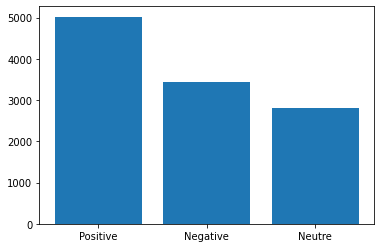

In [ ]:
class_counts=data_information(data)

# Equilibre

 0.0    4099
-1.0    4099
 1.0    4099
Name: label, dtype: int64


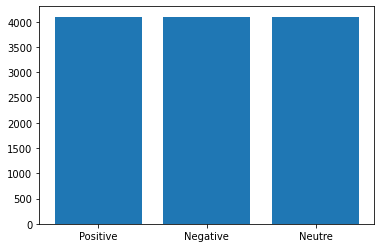

 0.0    4099
-1.0    4099
 1.0    4099
Name: label, dtype: int64

In [ ]:
# pour rendre l'ensemble de données equilibré.
pos = data[data['label'] ==1]
neg = data[data['label'] == -1]
neu = data[data['label'] == 0]

max_len = min(len(pos), len(neg), len(neu))

data_ = []
for i in range(max_len):
  data_ += [{'text' : pos.iloc[i]['text'], 'label' : pos.iloc[i]['label']}]
  data_ += [{'text' : neg.iloc[i]['text'], 'label' : neg.iloc[i]['label']}]
  data_ += [{'text' : neu.iloc[i]['text'], 'label' : neu.iloc[i]['label']}]

data = pd.DataFrame(data_)
data_information(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Vectorisation of text

In [ ]:
# séparer l'attribut TEXT de l'attribut CLASSES.
X = data['text'].values
Y = data['label'].values
print(type(Y))

# calculer le nombre de token dans l'ensemble de données.
max_words = len(counter_word(data.text))
print(max_words)

<class 'numpy.ndarray'>
26454


**Split**

In [ ]:
# découpage des données en test et apprentissage 10% teste et 90% pour l'apprentissage et validation
x_train,x_test,y_train,y_test=split(X,Y,0.1)
y_train,y_test=categorial(y_train,y_test)

**BOW**

In [ ]:
## Step 1: Determine the Vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
print(f'Vocabulary: {list(tokenizer.word_index.keys())}')

## Step 2: Count
train_bow = tokenizer.texts_to_matrix(x_train, mode='count')
test_bow = tokenizer.texts_to_matrix(x_test, mode='count')

Vocabulary: ['اله', 'ال', 'يا', 'الجزائر', 'ربي', 'شكرا', 'انا', 'إعادة', 'ا', 'عظم', 'و', 'الشعب', 'كي', 'الله', 'تحيا', 'الى', 'ألغ', 'شيء', 'لطفي', 'واله', 'لك', 'بزاف', 'لكم', 'ضفيرة', 'جزيلا', 'ربيع', 'واش', 'ام', 'كنت', 'فرنسا', 'ألجيري', 'الخير', 'حب', 'حاجة', 'مبروك', 'خير', 'يجب', 'دي', 'ل', 'الناس', 'تاع', 'يرحمو', 'شرم', 'حدة', 'لى', 'مكن', 'صح', 'ه', 'مرحبا', 'هادي', 'بزف', 'يضحك', 'راه', 'مشي', 'الجبن', 'يبارك', 'رياض', 'فرك', 'داسيا', 'آنا', 'شعب', 'بك', 'رجال', 'شباب', 'الهواء', 'انت', 'تونس', 'مرة', 'أكثر', 'لنا', 'ك', 'تأتي', 'خويا', 'نشالله', 'دولة', 'جازي', 'ناس', 'الشرق', 'جيد', 'فاي', 'ليب', 'شركة', 'شاء', 'ليبيا', 'بلدي', 'الهم', 'الدولة', 'السعر', 'قلت', 'كامل', 'هاتف', 'راني', 'الحق', 'راك', 'الجزائري', 'تقوم', 'متر', 'الدجاج', 'الغير', 'وش', 'كيما', 'هواء', 'راكم', 'حنا', 'براندت', 'بدون', 'صباحا', 'ندير', 'ي', 'سلام', 'أعلى', 'كاين', 'شابة', 'حظ', 'الصحة', 'حد', 'كونستنتين', 'اسد', 'الكل', 'انشالله', 'رر', 'بنينة', 'دجاج', 'الصباح', 'وقت', 'فري', 'العالم', 'دا

**Word Embedding**

`Préparation des données pour l'encodage WE.`

In [ ]:
train_padded,test_padded,voc_size=one_hot_encoding(x_train,x_test,max_words,2000)

# BLSTM

`Plusieurs architectures BLSTM avec l'entré WE`

In [ ]:
def bidirectional_lstm_em(n,train_padded):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(n,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])  
    return model

def bidirectional_lstm_2em(n,train_padded):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(n,dropout=0.5,return_sequences=True)))
    model.add(Bidirectional(LSTM(n,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])  
    return model

def bidirectional_lstm_3em(n,train_padded):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(n,dropout=0.5,return_sequences=True)))
    model.add(Bidirectional(LSTM(n,dropout=0.5,return_sequences=True)))
    model.add(Bidirectional(LSTM(n,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])  
    return model


def blstm_fit(model,train_padded,y_train):
  # fit network
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

def blstm_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)
  print('Accuracy:', result[1])
  return result


`Exécution de plusieurs architectures BLSTM en variant le nombre de neouds.`

In [ ]:
for x in [10,20,30,40,50,60]:
  model=bidirectional_lstm_em(x,train_padded)
  model,history=blstm_fit(model,train_padded,y_train)
  result1=blstm_evaluation(model,test_padded,y_test)

  model2=bidirectional_lstm_2em(x,train_padded)
  model2,history2=blstm_fit(model2,train_padded,y_train)
  result2=blstm_evaluation(model2,test_padded,y_test)

  model3=bidirectional_lstm_3em(x,train_padded)
  model3,history3=blstm_fit(model3,train_padded,y_train)
  result3=blstm_evaluation(model3,test_padded,y_test)
  

**10 cross validation**

# CNN

`Plusieurs architectures CNN avec l'entré BOW et WE`

In [ ]:
def cnn_model_2345_conv_em(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)
    conv_3 = Conv1D(num_filters, kernel_size=5, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)
    maxpool_3 = MaxPooling1D(pool_size=2)(conv_3)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2,maxpool_3])
    model = Flatten()(concatenated_tensor)

    #model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_234_conv_em(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = Flatten()(concatenated_tensor)

    #model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_23_conv_em(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = Flatten()(concatenated_tensor)

    #model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_2_conv_em(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)

    model = Flatten()(maxpool_0)

    #model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


#------------------------------------------------------------------------------ BOW

def cnn_model_2345_conv_bow(train_padded,voc_size,act):
    vocabulary_size = voc_size
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = X_train.shape[1] # 20
    inp = Input(shape=(sequence_length,1))

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(inp)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(inp)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(inp)
    conv_3 = Conv1D(num_filters, kernel_size=5, padding='valid', activation=act)(inp)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)
    maxpool_3 = MaxPooling1D(pool_size=2)(conv_3)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2,maxpool_3])
    model = Flatten()(concatenated_tensor)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_234_conv_bow(train_padded,voc_size,act):
    vocabulary_size = voc_size
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = X_train.shape[1] # 20
    inp = Input(shape=(sequence_length,1))


    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(inp)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(inp)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(inp)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = Flatten()(concatenated_tensor)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_23_conv_bow(train_padded,voc_size,act):
    vocabulary_size = voc_size
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = X_train.shape[1] # 20
    inp = Input(shape=(sequence_length,1))


    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(inp)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(inp)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = Flatten()(concatenated_tensor)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

def cnn_model_2_conv_bow(train_padded,voc_size,act):
    vocabulary_size = voc_size
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = X_train.shape[1] # 20
    inp = Input(shape=(sequence_length,1))


    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(inp)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)

    model = Flatten()(maxpool_0)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


def cnn_fit(model,train_padded,y_train):
  # fit network
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

def cnn_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)
  print('Accuracy:', result[1])
  return result


In [ ]:
print("----------------- mataoui umBALANCED-------------------:: ")
print("relu ::  ")
for x in ['cnn_2_no_dense_em.h5']:

  model=open_model("CNN/Embedding/mataoui umbalanced/relu/"+x)
  print(x)
  cnn_evaluation(model,test_padded,y_test)


----------------- mataoui umBALANCED-------------------:: 
relu ::  
cnn_2_no_dense_em.h5
36/36 [==============================] - 0s 7ms/step - loss: 0.8788 - accuracy: 0.6011
Accuracy: 0.6010638475418091


Epoch 1/20
92/92 [==============================] - 6s 67ms/step - loss: 1.0709 - accuracy: 0.4413 - val_loss: 1.0646 - val_accuracy: 0.4587
Epoch 2/20
92/92 [==============================] - 6s 64ms/step - loss: 1.0678 - accuracy: 0.4428 - val_loss: 1.0591 - val_accuracy: 0.4596
Epoch 3/20
92/92 [==============================] - 6s 63ms/step - loss: 1.0623 - accuracy: 0.4455 - val_loss: 1.0550 - val_accuracy: 0.4616
Epoch 4/20
92/92 [==============================] - 6s 62ms/step - loss: 1.0538 - accuracy: 0.4583 - val_loss: 1.0491 - val_accuracy: 0.4724
Epoch 5/20
92/92 [==============================] - 6s 61ms/step - loss: 1.0427 - accuracy: 0.4749 - val_loss: 1.0400 - val_accuracy: 0.4892
Epoch 6/20
92/92 [==============================] - 6s 62ms/step - loss: 1.0264 - accuracy: 0.4928 - val_loss: 1.0279 - val_accuracy: 0.5000
Epoch 7/20
92/92 [==============================] - 6s 62ms/step - loss: 1.0052 - accuracy: 0.5123 - val_loss: 1.0150 - val_accuracy: 0.5039
Epoch 8/20
92

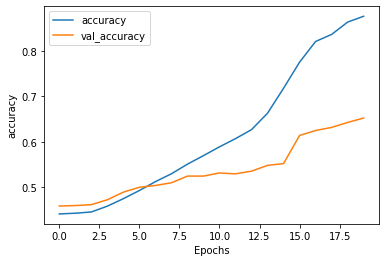

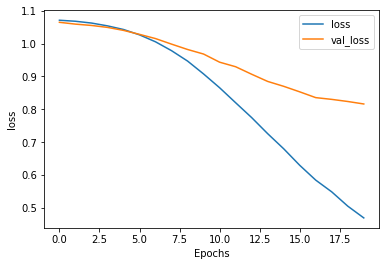

In [ ]:
model2=cnn_model_2_conv_em(train_padded,voc_size,'relu')
model2,history=cnn_fit(model2,train_padded,y_train)


In [ ]:
cnn_evaluation(model2,test_padded,y_test)


36/36 [==============================] - 0s 7ms/step - loss: 0.8436 - accuracy: 0.6418
Accuracy: 0.6418439745903015


[0.8436161279678345, 0.6418439745903015]

In [ ]:
for act in ['tanh']:
    print("------------------------------",act)
    model2=cnn_model_2_conv_bow(X_train,voc_size,act)
    model23=cnn_model_23_conv_bow(X_train,voc_size,act)
   
    model2,history=cnn_fit(model2,X_train,y_train)
    print('================= cnn_2_no_dense_bow.h5')
    savemodel(model2,'CNN/BOW/12k balanced/'+str(act)+'/cnn_2_dense_bow.h5')
    cnn_evaluation(model2,X_test,y_test)

    model23,history=cnn_fit(model23,X_train,y_train)
    print('================= cnn_23_no_dense_bow.h5')
    savemodel(model23,'CNN/BOW/12k balanced/'+str(act)+'/cnn_23_dense_bow.h5')
    cnn_evaluation(model23,X_test,y_test)

   

In [ ]:
for act in ['tanh']:
    print("------------------------------",act)
   
    model234=cnn_model_234_conv_bow(X_train,voc_size,act)
    model2345=cnn_model_2345_conv_bow(X_train,voc_size,act)

    model234,history=cnn_fit(model234,X_train,y_train)
    print("================= cnn_234_no_dense_bow.h5")
    savemodel(model234,'CNN/BOW/12k balanced/'+str(act)+'/cnn_234_dense_bow.h5')
    cnn_evaluation(model234,X_test,y_test)

    model2345,history=cnn_fit(model2345,X_train,y_train)
    print("================= cnn_2345_no_dense_bow.h5")
    savemodel(model2345,'CNN/BOW/12k balanced/'+str(act)+'/cnn_2345_dense_bow.h5')
    cnn_evaluation(model234,X_test,y_test)

`Reshape to use BOW`

In [ ]:
X_train = np.array(train_bow).reshape((train_bow.shape[0], train_bow.shape[1], 1))
X_test = np.array(test_bow).reshape((test_bow.shape[0], test_bow.shape[1], 1))

In [ ]:
savemodel(model,'CNN/Embedding/12k balanced/relu/dense layer/cnn_em_234.h5')

# CNN-BLSTM

`Plusieurs architectures CNN-BLSTM avec l'entré WE`

In [ ]:
def Blstm_CNN():
    X_train = np.array(x_train_bow).reshape((x_train_bow.shape[0], x_train_bow.shape[1], 1))
    X_test = np.array(x_test_bow).reshape((x_test_bow.shape[0], x_test_bow.shape[1], 1))

    model = Sequential()
    model.add(Bidirectional(LSTM(64 ,return_sequences=True),input_shape=(X_train.shape[1],1)))

    model.add(Conv1D(filters=16, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(150))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(y_train.shape[1],activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    model.summary()


def cnn_23_blstm(n,train_padded,act='relu'):
    vocabulary_size = voc_size
    embedding_dim = 100
    filter_size = 5
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = concatenated_tensor
    model = Bidirectional(LSTM(n,dropout=0.5))(model)
    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

def cnn_2_blstm(n,train_padded,act='tanh'):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)

    model = maxpool_0

    model = Bidirectional(LSTM(n,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model



def cnn_234_blstm(n,train_padded,act='relu'):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = concatenated_tensor

    model = Bidirectional(LSTM(n,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

def cnn_blstm_fit(model,train_padded,y_train):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

def cnn_blstm_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)
  print('Accuracy:', result[1])
  return result

`Exemple d'exécution de plusieurs architecture CNN-BLSTM en variant le nombre de neouds.`

In [ ]:
for x in [10,20,30]:
  model=cnn_2_blstm(x,train_padded)
  model,history=cnn_blstm_fit(model,train_padded,y_train)
  result1=cnn_blstm_evaluation(model,test_padded,y_test)


  model2=cnn_23_blstm(x,train_padded)
  model2,history2=cnn_blstm_fit(model2,train_padded,y_train)
  result2=cnn_blstm_evaluation(model2,test_padded,y_test)

  model3=cnn_234_blstm(x,train_padded)
  model3,history3=cnn_blstm_fit(model3,train_padded,y_train)
  result3=cnn_blstm_evaluation(model3,test_padded,y_test)

# MLP

`Plusieurs architectures MLP avec l'entré BOW`

In [ ]:
def mlp_model_1bow(train_padded,noeud,act):

    model = Sequential()
    model.add(Dense(noeud, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


def mlp_model_2bow(train_padded,noeud,act):
    sequence_length = train_padded.shape[1] # 20

    model = Sequential()
    model.add(Dense(noeud, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(noeud, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

def mlp_model_3bow(train_padded,noeud,act):

    model = Sequential()
    model.add(Dense(noeud, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(noeud, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(noeud, kernel_initializer='he_normal'))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

def mlp_fit(model,train_padded,y_train):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

def mlp_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)
  print('Accuracy:', result[1])
  return result

`MLP bow`

**Reshape data to BOW**

In [ ]:
X_train = np.array(train_bow).reshape((train_bow.shape[0], train_bow.shape[1], 1))
X_test = np.array(test_bow).reshape((test_bow.shape[0], test_bow.shape[1], 1))

`Exemple d'exécution de plusieurs architectures MLP en variant le nombre de neouds et la fontion d'activation.`

In [ ]:
for mm in [50,80]:
  for act in ['tanh']:

    model3=mlp_model_3bow(train_bow,mm,act)
    model2=mlp_model_2bow(train_bow,mm,act)
    model1=mlp_model_1bow(train_bow,mm,act)

    model1,history=mlp_fit(model1,train_bow,y_train)
    savemodel(model1,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_1layer_'+str(mm)+'_bow.h5')

    model2,history=mlp_fit(model2,train_bow,y_train)
    savemodel(model2,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_2layer_'+str(mm)+'_bow.h5')

    model3,history=mlp_fit(model3,train_bow,y_train)
    savemodel(model3,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_3layer_'+str(mm)+'_bow.h5')

    result1=mlp_evaluation(model1,train_bow,y_test)
    result2=mlp_evaluation(model2,train_bow,y_test)
    result3=mlp_evaluation(model3,train_bow,y_test)



Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 1.0913 - accuracy: 0.4233 - val_loss: 1.0793 - val_accuracy: 0.4567
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 1.0638 - accuracy: 0.4712 - val_loss: 1.0477 - val_accuracy: 0.4613
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 1.0282 - accuracy: 0.4822 - val_loss: 1.0127 - val_accuracy: 0.4724
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 0.9839 - accuracy: 0.5142 - val_loss: 0.9718 - val_accuracy: 0.5217
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 0.9378 - accuracy: 0.5667 - val_loss: 0.9263 - val_accuracy: 0.5610
Epoch 6/20
138/138 [==============================] - 1s 10ms/step - loss: 0.8750 - accuracy: 0.6295 - val_loss: 0.8784 - val_accuracy: 0.6050
Epoch 7/20
138/138 [==============================] - 1s 10ms/step - loss: 0.8098 - accuracy: 0.6843 - val_loss: 0.8351 - val_accuracy: 0.6424

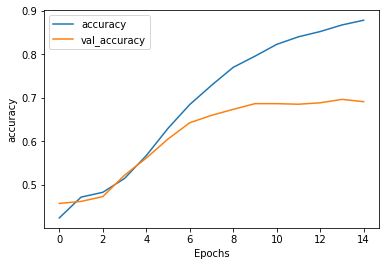

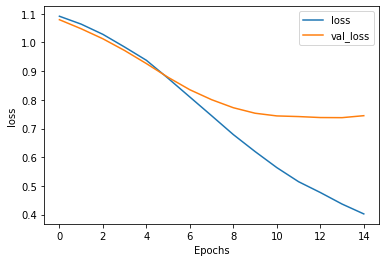

Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 1.0854 - accuracy: 0.4427 - val_loss: 1.0659 - val_accuracy: 0.4554
Epoch 2/20
138/138 [==============================] - 1s 11ms/step - loss: 1.0441 - accuracy: 0.4704 - val_loss: 1.0212 - val_accuracy: 0.4678
Epoch 3/20
138/138 [==============================] - 2s 11ms/step - loss: 0.9863 - accuracy: 0.5017 - val_loss: 0.9648 - val_accuracy: 0.5131
Epoch 4/20
138/138 [==============================] - 2s 11ms/step - loss: 0.9152 - accuracy: 0.5791 - val_loss: 0.9001 - val_accuracy: 0.5840
Epoch 5/20
138/138 [==============================] - 1s 11ms/step - loss: 0.8324 - accuracy: 0.6504 - val_loss: 0.8418 - val_accuracy: 0.6280
Epoch 6/20
138/138 [==============================] - 2s 11ms/step - loss: 0.7444 - accuracy: 0.7132 - val_loss: 0.7989 - val_accuracy: 0.6614
Epoch 7/20
138/138 [==============================] - 1s 11ms/step - loss: 0.6642 - accuracy: 0.7657 - val_loss: 0.7678 - val_accuracy: 0.6732

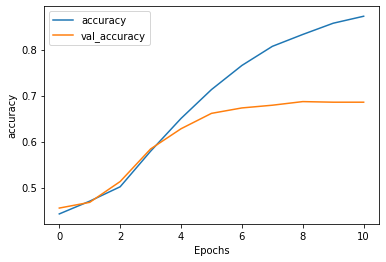

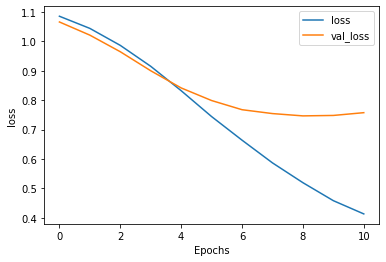

In [ ]:
for mm in [50,80]:
  for act in ['relu']:

    model3=mlp_model_3bow(train_bow,mm,act)
    model2=mlp_model_2bow(train_bow,mm,act)
    model1=mlp_model_1bow(train_bow,mm,act)

    model1,history=mlp_fit(model1,train_bow,y_train)
    savemodel(model1,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_1layer_'+str(mm)+'_bow.h5')

    model2,history=mlp_fit(model2,train_bow,y_train)
    savemodel(model2,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_2layer_'+str(mm)+'_bow.h5')

    model3,history=mlp_fit(model3,train_bow,y_train)
    savemodel(model3,'MLP/BOW/16k umbalanced/'+str(act)+'/mlp_3layer_'+str(mm)+'_bow.h5')

    result1=mlp_evaluation(model1,train_bow,y_test)
    result2=mlp_evaluation(model2,train_bow,y_test)
    result3=mlp_evaluation(model3,train_bow,y_test)
